In [1]:
#CIS Username:dgll43

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time, sys
from google.colab import files
import os

### Initial Dataset loading and formatting

In [3]:
#Collect and unzip the OULAD dataset
#The data is available from https://github.com/ThomasWWebb/learning-analytics and the original data can be found at https://analyse.kmi.open.ac.uk/open_dataset
!sudo apt-get install unzip
!wget https://raw.githubusercontent.com/thomaswwebb/learning-analytics/master/OULAD/oulad.zip
!unzip oulad.zip -d OULAD

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
--2021-05-31 08:43:00--  https://raw.githubusercontent.com/thomaswwebb/learning-analytics/master/OULAD/oulad.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47552529 (45M) [application/zip]
Saving to: ‘oulad.zip’

oulad.zip           100%[===================>]  45.35M  56.4MB/s    in 0.8s    

2021-05-31 08:43:01 (56.4 MB/s) - ‘oulad.zip’ saved [47552529/47552529]

Archive:  oulad.zip
  inflating: OULAD/as

In [4]:
#Load the dataset into the notebook
student_info = pd.read_csv('OULAD/studentInfo.csv', engine='python')
student_reg = pd.read_csv('OULAD/studentRegistration.csv', engine='python')
courses = pd.read_csv('OULAD/courses.csv', engine='python')
assessments = pd.read_csv('OULAD/assessments.csv', engine='python')
student_assessment = pd.read_csv('OULAD/studentAssessment.csv', engine='python')
student_vle = pd.read_csv("OULAD/studentVle.csv", engine='c')
vle = pd.read_csv('OULAD/vle.csv', engine='python')

In [5]:
#Selects the subsection of the OULAD dataset that we focus upon in this work
min_code_presentation = "2014B"
min_code_module = "DDD"
min_student_info = student_info[(student_info.code_module==min_code_module) & (student_info.code_presentation == min_code_presentation)]

In [6]:
#Merge tables for more efficient feature engineering later on
merged_student_vle = pd.merge(student_vle, vle,  how="left", on=["code_module","code_presentation", "id_site"])
merged_assessments = pd.merge(student_assessment, assessments, how="left", on="id_assessment")
merged_assessments = pd.merge(merged_assessments, courses,  how="left", on=["code_module", "code_presentation"])
merged_assessments.date=np.select([merged_assessments['assessment_type'] =="Exam"],[merged_assessments.module_presentation_length],default=merged_assessments.date) #Exams take place in the last week of teaching

### Feature Engineering

In [7]:
def get_extra_features(student_info, merged_assessments, assessments, merged_student_vle, time_prop): #Generates the aggregate features set out in the Feature engineering section of the paperfor a given duration of the course
  relative_scores = []
  late_scores = []
  raw_score = []

  sum_clicks = []
  collab_clicks = []
  course_struct_clicks = []
  course_content_clicks = []
  eval_clicks = []
  assess_complete = []

  #Defines the activity types for each commitment feature type
  collab_types = ["forumng", "ouwiki", "oucollaborate", "ouelluminate"]
  course_struct_types = ["glossary", "homepage", "dataplus", "folder"]
  course_content_types = ["resource", "url", "oucontent", "page", "subpage", "sharedsubpage", "repeatactivity", "dualpane", "repeatactivity"]
  eval_types = ["quiz", "questionnaire", "externalquiz"]

  for index, row in student_info.iterrows():
    id_student = row.id_student
    code_module = row.code_module
    code_presentation = row.code_presentation
    date_cutoff = time_prop * merged_assessments.iloc[0].module_presentation_length #the final date of the given course proportion
    #All assessments this student has completed regardless of cutoff date
    indiv_student_assess = merged_assessments[(merged_assessments.id_student == id_student) & (merged_assessments.code_module == code_module) & (merged_assessments.code_presentation == code_presentation) ]
    module_assess = assessments[(assessments.code_module == code_module) & (assessments.code_presentation == code_presentation)]
    max_weight = module_assess.weight.sum()
    max_assess = len(module_assess.weight)
    pair_assess = indiv_student_assess[indiv_student_assess.date_submitted <= date_cutoff]#Only assessment submitted before or on the cutoff date
    late_assess = pair_assess[pair_assess.date_submitted >  pair_assess.date] # proportion of assessments submitted late 
    late_scores.append(len(late_assess))
    raw_score.append(pair_assess.score.sum()) #unweighted sum of assessment scores so far 
    relative_scores.append((pair_assess.score * (pair_assess.weight/max_weight)).sum()) # weighted sum of assessment scores
    assess_complete.append(len(pair_assess.score)/max_assess) #proportion of assessments completed
    #All student interactions up until the cutoff date
    student_clicks = merged_student_vle[(merged_student_vle.id_student == id_student) & (merged_student_vle.code_module == code_module) & (merged_student_vle.code_presentation == code_presentation) & (merged_student_vle.date <= date_cutoff)]
    sum_clicks.append(student_clicks.sum_click.sum()) #sum of all clicks 
    collab_clicks.append(student_clicks[student_clicks.activity_type.isin(collab_types)].sum_click.sum()) #each click sum here and below is the sum of interactions for the previously defined sets of activity types
    course_struct_clicks.append(student_clicks[student_clicks.activity_type.isin(course_struct_types)].sum_click.sum())
    course_content_clicks.append(student_clicks[student_clicks.activity_type.isin(course_content_types)].sum_click.sum())
    eval_clicks.append(student_clicks[student_clicks.activity_type.isin(eval_types)].sum_click.sum())
    if len(relative_scores) % 100 == 0:
      perc = round(len(relative_scores) / len(student_info) * 100, 0)
      sys.stdout.write("\r" + f"{perc}% completed")
      sys.stdout.flush()
  perc = round(len(relative_scores) / len(student_info) * 100, 0)
  sys.stdout.write("\r" + f"{perc}% completed")
  sys.stdout.flush()
  return relative_scores, late_scores, raw_score, sum_clicks, collab_clicks, course_struct_clicks, course_content_clicks, eval_clicks, assess_complete

def add_extra_features(min_student_info, engineered_features): #Adds the extracted features as new columns in the student information dataframe
  expanded_student_info = min_student_info.copy()
  expanded_student_info = expanded_student_info.assign(relative_score = engineered_features[0])
  expanded_student_info = expanded_student_info.assign(late_score = engineered_features[1])
  expanded_student_info = expanded_student_info.assign(raw_score = engineered_features[2])
  expanded_student_info = expanded_student_info.assign(sum_click = engineered_features[3])
  expanded_student_info = expanded_student_info.assign(collab_click = engineered_features[4])
  expanded_student_info = expanded_student_info.assign(course_struct_click = engineered_features[5])
  expanded_student_info = expanded_student_info.assign(course_content_click = engineered_features[6])
  expanded_student_info = expanded_student_info.assign(eval_click = engineered_features[7])
  expanded_student_info = expanded_student_info.assign(assess_complete = engineered_features[8])
  return expanded_student_info

def convert_to_numeric_df(expanded_student_info): #Encodes the non-numeric entries of student data, encoding as a sequence for ordinal categories and using label encoding for non-ordinal categorical data
  expanded_student_info.gender = expanded_student_info.gender.replace({"M":0, "F":1})
  expanded_student_info.highest_education = expanded_student_info.highest_education.replace({"No Formal quals":0, "Lower Than A Level":1, "A Level or Equivalent":2, "HE Qualification":3, "Post Graduate Qualification":4})
  expanded_student_info.imd_band = expanded_student_info.imd_band.replace(['0-10%','10-20', '20-30%', '30-40%','40-50%', '50-60%','60-70%','70-80%','80-90%','90-100%'], [0,1,2,3,4,5,6,7,8,9])
  expanded_student_info.imd_band = expanded_student_info.imd_band.fillna(int(round(expanded_student_info.imd_band.mean(), 0)))
  expanded_student_info.age_band = expanded_student_info.age_band.replace(['0-35','35-55','55<='], [0,1,2])
  expanded_student_info.disability = expanded_student_info.disability.replace({"N":0, "Y":1})
  expanded_student_info.final_result = expanded_student_info.final_result.replace({"Withdrawn":1, "Fail":0, "Pass":0, "Distinction":0})  
  expanded_student_info.code_module = expanded_student_info.code_module.astype('category')
  expanded_student_info.code_module = expanded_student_info.code_module.cat.codes
  expanded_student_info.code_presentation = expanded_student_info.code_presentation.astype('category')
  expanded_student_info.code_presentation = expanded_student_info.code_presentation.cat.codes
  expanded_student_info.region = expanded_student_info.region.astype('category')
  expanded_student_info.region = expanded_student_info.region.cat.codes  
  return expanded_student_info

**The cell below will extract and append the new features to generate a set of vectors for each course duration - this will take around two hours. An alternative in the cell below reads in pre-extracted features from the same repository from which the dataset was read in**

In [ ]:
time_props = [0.25, 0.5, 0.75, 1.0]
expanded_student_infos = []
for time_prop in time_props:
  engineered_features = get_extra_features(min_student_info, merged_assessments, assessments, merged_student_vle, time_prop=time_prop)
  expanded_student_info = add_extra_features(min_student_info, engineered_features)
  expanded_student_infos.append(expanded_student_info)

1.0
100.0% completed

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
#The alternative to re-running the feature extraction above
!wget https://raw.githubusercontent.com/thomaswwebb/learning-analytics/master/expanded_student_info.zip
!unzip expanded_student_info.zip -d expanded_student_info
time_props = [25, 50, 75, 100]
expanded_student_infos = []
for time_prop in time_props:
  expanded_student_infos.append(pd.read_csv(f'expanded_student_info/expanded_student_info_DDD_14B_{time_prop}.csv', engine='python', index_col=0))

--2021-05-31 08:43:25--  https://raw.githubusercontent.com/thomaswwebb/learning-analytics/master/expanded_student_info.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138214 (135K) [application/zip]
Saving to: ‘expanded_student_info.zip’

expanded_student_in 100%[===================>] 134.97K  --.-KB/s    in 0.02s   

2021-05-31 08:43:25 (5.92 MB/s) - ‘expanded_student_info.zip’ saved [138214/138214]

Archive:  expanded_student_info.zip
  inflating: expanded_student_info/expanded_student_info_DDD_14B_100.csv  
  inflating: expanded_student_info/expanded_student_info_DDD_14B_25.csv  
  inflating: expanded_student_info/expanded_student_info_DDD_14B_50.csv  
  inflating: expanded_student_info/expanded_student_info_DDD_14B_75.csv  


In [9]:
#Encodes the non-numeric data for each course duration feature set
#We encode course completition by a learner as 0 and dropout as 1
for index in range(len(expanded_student_infos)):
  expanded_student_infos[index] = convert_to_numeric_df(expanded_student_infos[index])
expanded_student_infos[0].head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,relative_score,late_score,raw_score,sum_click,collab_click,course_struct_click,course_content_click,eval_click,assess_complete
16332,0,0,24213,1,0,2,4.0,0,1,60,0,0,9.5875,1,169.0,749,430,113,206,0,0.285714
16333,0,0,28149,0,0,2,6.0,1,0,60,0,1,0.0000,0,0.0,0,0,0,0,0,0.000000
16334,0,0,31269,1,1,2,3.0,1,1,120,0,1,6.4375,0,112.0,530,183,115,232,0,0.285714
16335,0,0,35502,0,11,3,3.0,0,0,60,0,1,3.3000,0,66.0,545,55,169,317,4,0.142857
16336,0,0,39660,1,5,1,0.0,0,0,120,0,0,9.5625,0,170.0,474,135,150,184,5,0.285714


### **Exploratory Data Analysis (Descriptive)**

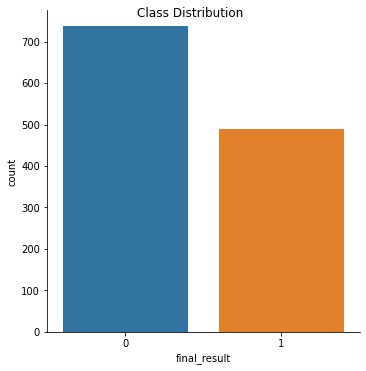

              id_student
final_result            
0                    738
1                    490


In [10]:
class_dist_plot = sns.catplot(x="final_result", data=expanded_student_infos[0], kind="count", height=5) #Plotting the class distribution, which will be contstant over time.
class_dist_plot.fig.suptitle("Class Distribution")
plt.show()
print(expanded_student_infos[0][["id_student", "final_result"]].groupby('final_result').count())

We find that there is a class imbalance with dropouts (1) as the minority class. There are 738 samples of students who complete the course and only 490 students that withdraw, resulting in a 60.1%/39.9% imbalance

### Feature Correlation

In [12]:
from collections import Counter
import scipy.stats as ss
import matplotlib.pyplot as plt
import math

#https://www.kaggle.com/akshay22071995/alone-in-the-woods-using-theil-s-u-for-survival
def conditional_entropy(x,y): #claculates how much information one variable contains about the other for use in the uncertainty coefficient
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

#https://www.kaggle.com/akshay22071995/alone-in-the-woods-using-theil-s-u-for-survival
def theil_u(x,y): #Thiel's U, or the uncertainty coefficient, can be used as an alternative for correlation when examining non-ordinal categorical data
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

def show_theiel_u(df, figsize=(7,7), columns=None): #applies Thiel's U to the sepecified columns of a dataframe
  if columns is None:
    columns = list(student_info.columns)
  big_theilu = pd.DataFrame()
  for i in range(0,len(columns)):
    theilu = pd.DataFrame(index=[columns[i]],columns=columns)
    for j in range(0,len(columns)):
        u = theil_u(df[columns[i]].tolist(),df[columns[j]].tolist())
        theilu.loc[:,columns[j]] = u
    big_theilu = big_theilu.append(theilu)
  big_theilu.fillna(value=np.nan,inplace=True)
  plt.figure(figsize=figsize)
  sns.heatmap(big_theilu,annot=True,fmt='.2f', cmap="Greens", vmin=0, vmax=1)
  plt.show()

def show_pearson(df, cmap="vlag", figsize=(10,5)): #Displays a heatmap for the calculated pearson coefficient values
  plt.figure(figsize=figsize)
  sns.heatmap(df.corr(),cmap=cmap,annot=True, vmin=-1, vmax=1) 

To evaluate the correlation between non-ordinal catgeorical variables and the final result we use the uncertainty coeffcicient/Thiel's U 

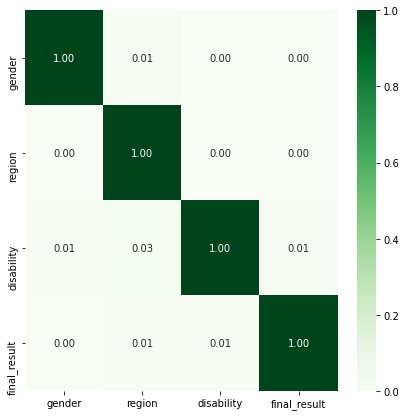

In [13]:
columns = ["gender", "region", "disability", "final_result"] #student_info.columns
show_theiel_u(expanded_student_infos[0], (7,7), columns)

Only disability can be used to slightly decrease the uncertainty of the final result, the other non-ordinal categorical data have a uncertainty coefficient of 0 and so do not impact the dropout probability. Interestingly this means a learner's gender and region do not impact their likelihood of dropout, at least for this specific course presentation. 

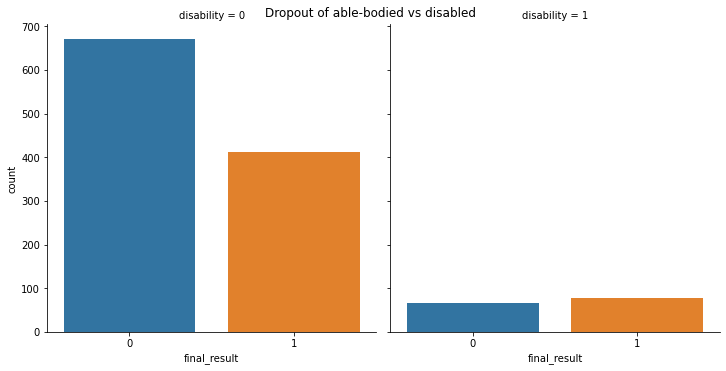

In [14]:
disability_plot = sns.catplot(x="final_result", col="disability", data=expanded_student_infos[0], kind="count", height=5)
disability_plot.fig.suptitle("Dropout of able-bodied vs disabled")
plt.show()

Learns with a disability are slightly more likely to dropout while those without are less likely to dropout. It's possible that this course may not be able to always effectively adapt to the needs of those with disabilities, or those with disabilities could be more likly to enounter situtations that result in their withdrawal 

In [15]:
#Re-ordering the columns to have final_result as the rightmost column in the heatmaps
column_list = expanded_student_infos[0].columns.tolist() 
column_list.pop(column_list.index("final_result"))
column_list.append("final_result")
expanded_student_infos[0] = expanded_student_infos[0][column_list]

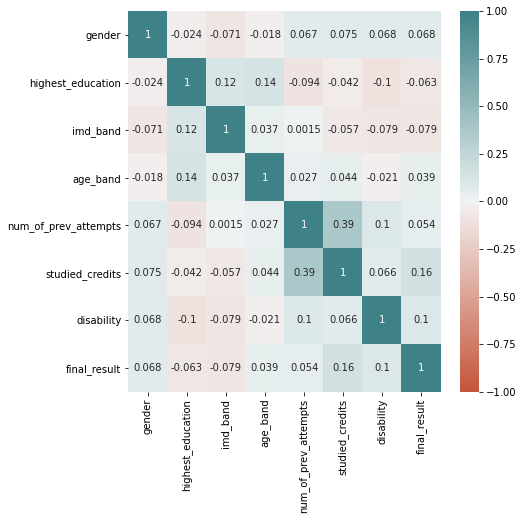

In [16]:
#Calculating pearson correlation for the student demographic data that remains constant over the course duration
expanded_features = ["relative_score", "late_score", "raw_score", "sum_click", "collab_click", "course_struct_click", "course_content_click", "eval_click", "assess_complete"]
show_pearson(expanded_student_infos[0].drop(["code_module", "code_presentation","id_student", "region"]+expanded_features, axis="columns"), cmap=sns.diverging_palette(20, 200, as_cmap=True), figsize=(7,7))

Examining the remaining demogrpahic features, alongside gender and didability that can be encoded in a sequential manner, we find that very few demonstrate any strong correlation. Disability exhibits a similar correlation as examined before and studied_credits has the strongest correlation at 0.16.

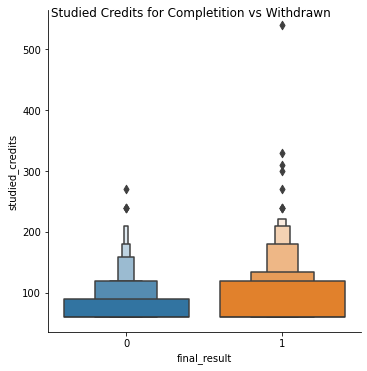

In [17]:
studied_credits_plot = sns.catplot(x="final_result", y="studied_credits", data=expanded_student_infos[0], height=5, kind="boxen")
studied_credits_plot.fig.suptitle("Studied Credits for Completition vs Withdrawn")
plt.show()

There are slightly different studied_credits distributions for learners who complete the module (0) compared to those who withdraw (1). We find that learners who have studied or are studying fewer credits are less likely to dropout while those later in their studies or studying more modules are more likely to dropout. This could be down to some learners intially registering for multiple modules and reducing the number as the courses progress. Similarly it may be due to students that select a smaller number of credits will be more nvested in those selected modules. 


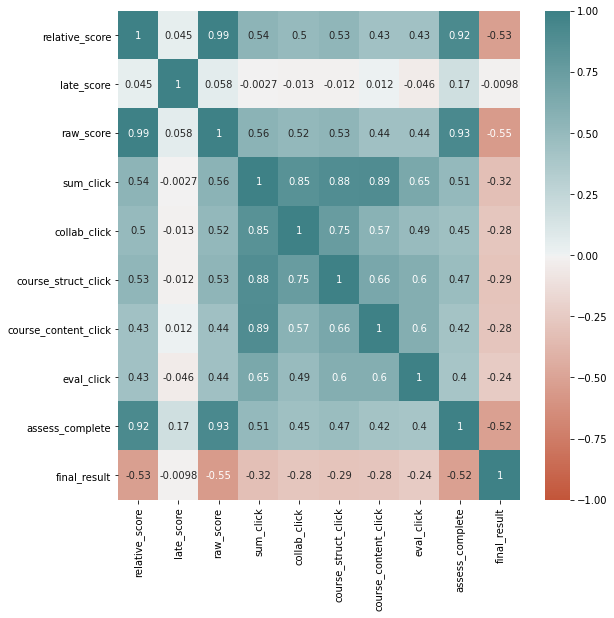

In [18]:
#Calculating pearson correlation for temporal clickstream features and assessment features
show_pearson(expanded_student_infos[0][expanded_features + ["final_result"]], cmap=sns.diverging_palette(20, 200, as_cmap=True), figsize=(9,9))

We calculate the pearson correlation coefficients our generated features based on temporal data that aim to capture higher level semantic information. We use the 25% propotion of the course duration feature vectors as part for demonstration of the analysis alongside the fact that featurs that are indicators from the earliest point in the course are the most valuable. 

Our generated features display a much higher level of correlation with the fina result than the previous demographic data. This demonstrates the importance of temporal data as well as the potential for this features to capture the indication of high-dimensional features in a low dimensional space. 

The raw score feature has the highest correlation at -0.55, a high value even with only 25% of the data. 

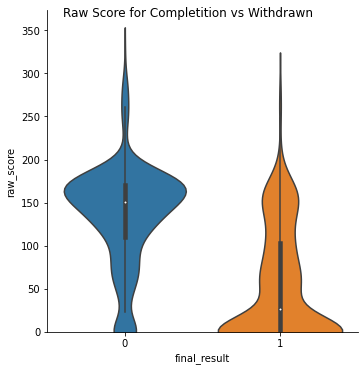

In [19]:
studied_credits_plot = sns.catplot(x="final_result", y="raw_score", data=expanded_student_infos[0], height=5, kind="violin")
studied_credits_plot.fig.suptitle("Raw Score for Completition vs Withdrawn")
plt.ylim(0, None)
plt.show()

Reasonably, the learners that continue the course to completion have a higher raw score on average, even with only 25% of the course completed. Learners that tend to dropout tend to have much lower raw scores at this point. 

### **Predictive Modelling (Predictive)**

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import datetime
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score, precision_score, recall_score, accuracy_score
from statistics import mean
import matplotlib.ticker as ticker

In [22]:
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, balanced_accuracy_score
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings

#Adapted from the LA-Descriptive-Predictive-Analytics.ipynb example notebook
#Trains and tests the given classifier over a k-foldrf dataset, averaging the fold results and returning them
def train_and_split_validation(clf, expanded_student_info, num_splits):
  smote = SMOTE(random_state=0)
  kf = KFold(n_splits=num_splits)
  kf.get_n_splits(expanded_student_info)
  split_data = []
  for train_index, test_index in kf.split(expanded_student_info):
    X_train, X_test = expanded_student_info.iloc[train_index].drop(["final_result"], axis="columns"), expanded_student_info.iloc[test_index].drop(["final_result"], axis="columns")
    y_train, y_test = expanded_student_info.iloc[train_index].final_result, expanded_student_info.iloc[test_index].final_result
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore")
      X_train, y_train = smote.fit_resample(X_train, y_train)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    #report = classification_report(y_test, y_pred) 
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore")
      cm = confusion_matrix(y_test, y_pred)
      recall = np.diag(cm) / np.sum(cm, axis = 1)
      recall = np.nan_to_num(recall)
      recall = np.append(recall, [mean(recall)])
      precision = np.diag(cm) / np.sum(cm, axis = 0)
      precision = np.nan_to_num(precision)
      precision = np.append(precision, [mean(precision)])
      accuracy = accuracy_score(y_test, y_pred)
      f1score = f1_score(y_test, y_pred,average=None)
      f1score = np.nan_to_num(f1score)
      f1score = np.append(f1score, [mean(f1score)])
    split_data.append(np.concatenate((precision,recall, f1score, np.array([accuracy]))))
  split_data = np.array(split_data)
  mean_data = np.mean(split_data, axis=0)
  return mean_data

#Trains and tests a aset of classifier, storing the k-folded averaged results in a dataframe
def train_test_classifiers(clfs, expanded_student_infos):
  columns = ['classifier', 'parameters', 'time_prop','precision_0', 'precision_1','precision_avg', 'recall_0','recall_1', 'recall_avg','f1score_0','f1score_1','f1score_avg','accuracy']
  results= pd.DataFrame( columns=columns)
  time_props = [0.25, 0.5, 0.75, 1.0]
  for clf in clfs:
    for index in range(len(time_props)):
      ClfResults = []
      mean_data = train_and_split_validation(clf, expanded_student_infos[index], num_splits=5)
      ClfResults.append(str(clf).split('(')[0])
      ClfResults.append(str(clf).split('(',1)[1])
      ClfResults.append(time_props[index])
      ClfResults = ClfResults + list(mean_data)
      results.loc[len(results.index)] = ClfResults
  return results

### Initial model evaluation

In [23]:
clfs = [
    RandomForestClassifier(random_state=0),
    ExtraTreesClassifier(random_state=0), 
    GradientBoostingClassifier(random_state=0),
    LogisticRegression(random_state=0, max_iter=2000), 
    SVC(random_state=0)
]
initial_results = train_test_classifiers(clfs, expanded_student_infos)
initial_results

,classifier,parameters,time_prop,precision_0,precision_1,precision_avg,recall_0,recall_1,recall_avg,f1score_0,f1score_1,f1score_avg,accuracy
0,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.25,0.804252,0.716990,0.760621,0.816991,0.697782,0.757386,0.810548,0.707141,0.758845,0.771973
1,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.50,0.843994,0.707910,0.775952,0.785071,0.777646,0.781359,0.812922,0.740525,0.776724,0.785024
2,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.75,0.858922,0.699665,0.779294,0.768841,0.807779,0.788310,0.810999,0.749461,0.780230,0.786657
3,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",1.00,0.920619,0.730510,0.825564,0.779106,0.899209,0.839158,0.843670,0.805802,0.824736,0.828186
4,ExtraTreesClassifier,"bootstrap=False, ccp_alpha=0.0, class_weight=N...",0.25,0.795498,0.733381,0.764440,0.833223,0.675087,0.754155,0.813763,0.702291,0.758027,0.773632
5,ExtraTreesClassifier,"bootstrap=False, ccp_alpha=0.0, class_weight=N...",0.50,0.832448,0.696100,0.764274,0.779592,0.758798,0.769195,0.804799,0.725677,0.765238,0.774432
6,ExtraTreesClassifier,"bootstrap=False, ccp_alpha=0.0, class_weight=N...",0.75,0.858122,0.704701,0.781412,0.775455,0.803294,0.789374,0.814181,0.750340,0.782260,0.789102
7,ExtraTreesClassifier,"bootstrap=False, ccp_alpha=0.0, class_weight=N...",1.00,0.893858,0.719227,0.806542,0.773467,0.862187,0.817827,0.828993,0.784194,0.806594,0.811107
8,GradientBoostingClassifier,"ccp_alpha=0.0, criterion='friedman_mse', init=...",0.25,0.809634,0.698539,0.754087,0.737483,0.730559,0.734021,0.742258,0.692627,0.717443,0.731163
9,GradientBoostingClassifier,"ccp_alpha=0.0, criterion='friedman_mse', init=...",0.50,0.838702,0.694792,0.766747,0.770700,0.779184,0.774942,0.802966,0.734068,0.768517,0.775258


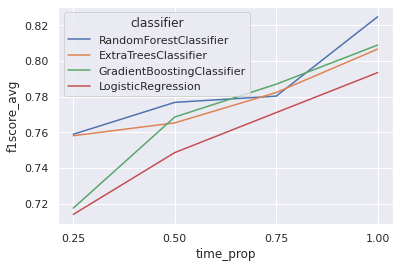

In [29]:
sns.set()
ax = sns.lineplot(data=initial_results[initial_results.classifier != "SVC"], x="time_prop", y="f1score_avg", hue="classifier", markers=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

A visualisation of classifier performance with average F1 score against the proportion of course data used. We omit SVC due to the large perfromance gap. We can see that Random Forest outperfoms or performs on par with models at every point except for 75% and so we select this model to fine-tune 

### Experimental fine-tuning of Random Forest

In [24]:
clfs = [
    RandomForestClassifier(random_state=0, n_estimators=500),
    RandomForestClassifier(random_state=0, n_estimators=1000),
    RandomForestClassifier(random_state=0, criterion="entropy"), 
    RandomForestClassifier(random_state=0, max_features="log2"), 
    RandomForestClassifier(random_state=0, n_estimators=1000, criterion="entropy"),
]
mod_results = train_test_classifiers(clfs, expanded_student_infos)
mod_results

,classifier,parameters,time_prop,precision_0,precision_1,precision_avg,recall_0,recall_1,recall_avg,f1score_0,f1score_1,f1score_avg,accuracy
0,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.25,0.803917,0.725260,0.764588,0.820971,0.695379,0.758175,0.812154,0.709277,0.760716,0.774442
1,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.50,0.846855,0.700530,0.773692,0.777394,0.784065,0.780730,0.810149,0.739391,0.774770,0.782572
2,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.75,0.866191,0.697698,0.781945,0.763424,0.820130,0.791777,0.811164,0.753623,0.782393,0.788283
3,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",1.00,0.927066,0.717876,0.822471,0.763025,0.908667,0.835846,0.836799,0.801788,0.819294,0.822472
4,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.25,0.805890,0.726486,0.766188,0.821016,0.699789,0.760403,0.813214,0.712292,0.762753,0.776068
5,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.50,0.847545,0.704573,0.776059,0.781506,0.784312,0.782909,0.812660,0.741711,0.777186,0.785014
6,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.75,0.866943,0.694082,0.780512,0.759644,0.821685,0.790664,0.809464,0.752310,0.780887,0.786647
7,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",1.00,0.927871,0.715325,0.821598,0.758600,0.910996,0.834798,0.834425,0.801136,0.817781,0.820850
8,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.25,0.801886,0.738173,0.770030,0.836510,0.684972,0.760741,0.818674,0.709893,0.764283,0.779316
9,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.50,0.841544,0.696298,0.768921,0.773647,0.773912,0.773780,0.805459,0.732382,0.768920,0.777684


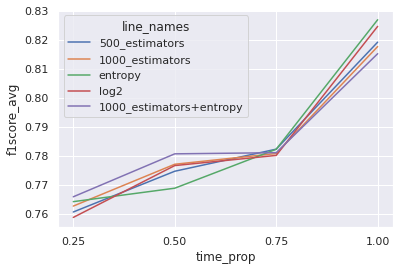

In [32]:
line_names = ["500_estimators"] * 4 + ["1000_estimators"] * 4 + ["entropy"] * 4 + ["log2"] *4 + ["1000_estimators+entropy"] * 4
mod_results = mod_results.assign(line_names = line_names)
ax = sns.lineplot(data=mod_results, x="time_prop", y="f1score_avg", hue="line_names", markers=True)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

While performance is mixed acorss the modification, 1000 estimators and entropy as the criterion leads to improved performance for the first two proportions and the earlier predictions are the most valbale within this task, and so we select these modification.

### Selected Random Forest Configuration

In [ ]:
clfs = [
    RandomForestClassifier(random_state=0, n_estimators=1000, criterion="entropy"),
]
rf_final_results = train_test_classifiers(clfs, expanded_student_infos)
rf_final_results

,classifier,parameters,time_prop,precision_0,precision_1,precision_avg,recall_0,recall_1,recall_avg,f1score_0,f1score_1,f1score_avg,accuracy
0,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.25,0.808040,0.730375,0.769208,0.825659,0.701628,0.763644,0.816637,0.715280,0.765959,0.779316
1,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.50,0.855786,0.705094,0.780440,0.776517,0.797378,0.786948,0.813637,0.747911,0.780774,0.788276
2,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",0.75,0.868532,0.693459,0.780996,0.756501,0.825920,0.791211,0.808444,0.753897,0.781170,0.786653
3,RandomForestClassifier,"bootstrap=True, ccp_alpha=0.0, class_weight=No...",1.00,0.932603,0.710291,0.821447,0.750074,0.916649,0.833361,0.830708,0.799919,0.815313,0.818407


In [ ]:
clfs = [
        VotingClassifier(estimators=[
                                     ('et', ExtraTreesClassifier(random_state=0),), 
                                     ('rf', RandomForestClassifier(random_state=0, n_estimators=1000, criterion="entropy")), 
                                     ('gb', GradientBoostingClassifier(random_state=0))], voting='hard'),
        VotingClassifier(estimators=[
                                     ('et', ExtraTreesClassifier(random_state=0),), 
                                     ('rf', RandomForestClassifier(random_state=0, n_estimators=1000, criterion="entropy")), 
                                     ('gb', GradientBoostingClassifier(random_state=0))], voting='soft')
]
ensemble_results = train_test_classifiers(clfs, expanded_student_infos)
ensemble_results



,classifier,parameters,time_prop,precision_0,precision_1,precision_avg,recall_0,recall_1,recall_avg,f1score_0,f1score_1,f1score_avg,accuracy
0,VotingClassifier,"estimators=[('et',\n ...",0.25,0.807167,0.738116,0.772641,0.832588,0.697287,0.764938,0.819509,0.716386,0.767947,0.781755
1,VotingClassifier,"estimators=[('et',\n ...",0.50,0.847412,0.692664,0.770038,0.767404,0.787702,0.777553,0.805149,0.736993,0.771071,0.778500
2,VotingClassifier,"estimators=[('et',\n ...",0.75,0.870782,0.697129,0.783955,0.761009,0.827825,0.794417,0.812047,0.756846,0.784446,0.789905
3,VotingClassifier,"estimators=[('et',\n ...",1.00,0.924861,0.715912,0.820386,0.759390,0.907186,0.833288,0.833659,0.800101,0.816880,0.820046
4,VotingClassifier,"estimators=[('et',\n ...",0.25,0.808505,0.727899,0.768202,0.820047,0.706526,0.763287,0.813779,0.715774,0.764776,0.776851
5,VotingClassifier,"estimators=[('et',\n ...",0.50,0.853888,0.699804,0.776846,0.771779,0.798879,0.785329,0.810603,0.745972,0.778288,0.785017
6,VotingClassifier,"estimators=[('et',\n ...",0.75,0.872792,0.698604,0.785698,0.762707,0.829520,0.796113,0.813818,0.758294,0.786056,0.791528
7,VotingClassifier,"estimators=[('et',\n ...",1.00,0.914105,0.721211,0.817658,0.771013,0.891544,0.831278,0.836173,0.796989,0.816581,0.820037
